In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import ipywidgets as widgets
import requests
from io import StringIO

## Importing Datasets

In [ ]:
def collect_data(dataset_id):
    base_url = "https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/"
    apikey = apikey
    dataset_id = dataset_id
    format = 'csv'

    url = f'{base_url}{dataset_id}/exports/{format}'
    params = {
        'select': '*',
        'limit': -1,  # all records
        'lang': 'en',
        'timezone': 'UTC',
        'api_key': apikey  # use if use datasets API_key permissions
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        # StringIO to read the CSV data
        url_content = response.content.decode('utf-8')
        dataset = pd.read_csv(StringIO(url_content), delimiter=';')
        return dataset
    else:
        print(f'Request failed with status code {response.status_code}')

In [ ]:
collect_data('pedestrian-counting-system-monthly-counts-per-hour')
collect_data('meshed-sensor-type-2')

## Dataset Cleaning and Merging

In [57]:
data = pd.read_csv("pedcount.csv")
data_sensor = pd.read_csv("sensorreadings.csv")

In [58]:
print(data.shape)
data.head()

(549976, 7)


,Sensor_Name,SensingDateTime(Hour),LocationID,Direction_1,Direction_2,Total_of_Directions,Location
0,Fra118_T,2023-06-06T03:00:00+10:00,51,1,4,5,"-37.80841815, 144.95906316"
1,Fra118_T,2023-06-06T04:00:00+10:00,51,7,5,12,"-37.80841815, 144.95906316"
2,Fra118_T,2023-06-06T06:00:00+10:00,51,10,22,32,"-37.80841815, 144.95906316"
3,Fra118_T,2023-06-06T11:00:00+10:00,51,94,136,230,"-37.80841815, 144.95906316"
4,Fra118_T,2023-06-06T12:00:00+10:00,51,166,126,292,"-37.80841815, 144.95906316"


In [59]:
print(data_sensor.shape)
data_sensor.head()

(31362, 8)


,time,dev_id,Sensor Name,temperature,humidity,battery,Lat Long,Location Picture Hyperlink
0,2023-02-26T14:37:18+11:00,r712-a7f7,Bench Hub,24.11,55.94,3,"-37.8030396, 144.965898",https://melbournetestbed.opendatasoft.com/asse...
1,2023-02-26T15:33:38+11:00,r712-a7f8,Elm,20.98,65.33,3,"-37.8027955, 144.9657785",https://melbournetestbed.opendatasoft.com/asse...
2,2023-02-26T15:37:32+11:00,r712-a7f7,Bench Hub,21.29,63.02,3,"-37.8030396, 144.965898",https://melbournetestbed.opendatasoft.com/asse...
3,2023-02-26T17:33:39+11:00,r712-a7f8,Elm,19.75,76.39,3,"-37.8027955, 144.9657785",https://melbournetestbed.opendatasoft.com/asse...
4,2023-02-26T17:37:19+11:00,r712-a7f7,Bench Hub,20.08,73.95,3,"-37.8030396, 144.965898",https://melbournetestbed.opendatasoft.com/asse...


In [60]:
data['datetime'] = pd.to_datetime(data['SensingDateTime(Hour)'], errors='coerce')
data_sensor['datetime'] = pd.to_datetime(data_sensor['time'], errors='coerce')

In [61]:
def remove_timezone(x):
     return x.replace(tzinfo=None)
    
data['datetime_no_tz'] = data['datetime'].apply(remove_timezone)
data_sensor['datetime_no_tz_unrounded'] = data_sensor['datetime'].apply(remove_timezone)

In [62]:
def round_down(dt):
    if dt.minute > 0 or dt.second > 0:
        dt -= datetime.timedelta(minutes=dt.minute, seconds=dt.second, microseconds=dt.microsecond)
    return dt

data_sensor['datetime_no_tz'] = data_sensor['datetime_no_tz_unrounded'].apply(round_down)

In [63]:
data_sensor_mean = data_sensor.groupby('datetime_no_tz').agg({'temperature': 'mean', 'humidity': 'mean'}).reset_index()

In [64]:
df_merged = pd.merge(data, data_sensor_mean[['datetime_no_tz', 'temperature', 'humidity']], on='datetime_no_tz', how='left')

In [65]:
df_merged['hour'] = df_merged['datetime_no_tz'].dt.time

In [66]:
df_merged.drop(columns=['SensingDateTime(Hour)','datetime'], inplace=True)
df_merged.rename(columns={'datetime_no_tz': 'datetime'}, inplace=True)

In [67]:
print(df_merged.shape)
df_merged.head()

(549976, 10)


,Sensor_Name,LocationID,Direction_1,Direction_2,Total_of_Directions,Location,datetime,temperature,humidity,hour
0,Fra118_T,51,1,4,5,"-37.80841815, 144.95906316",2023-06-06 03:00:00,16.736667,73.400000,03:00:00
1,Fra118_T,51,7,5,12,"-37.80841815, 144.95906316",2023-06-06 04:00:00,15.437500,77.325000,04:00:00
2,Fra118_T,51,10,22,32,"-37.80841815, 144.95906316",2023-06-06 06:00:00,17.006667,73.813333,06:00:00
3,Fra118_T,51,94,136,230,"-37.80841815, 144.95906316",2023-06-06 11:00:00,18.130000,73.372500,11:00:00
4,Fra118_T,51,166,126,292,"-37.80841815, 144.95906316",2023-06-06 12:00:00,18.923333,68.420000,12:00:00


## Number of pedestrians based on time, temperature and humidity

In [74]:
hour = '12:00:00'
temp_or_hum = 'temperature'

In [70]:
df_hourly = df_merged[(df_merged['hour'] == pd.to_datetime(hour).time())]

In [72]:
q1 = df_hourly['Total_of_Directions'].quantile(0.25)
q3 = df_hourly['Total_of_Directions'].quantile(0.75)

iqr = q3 - q1

lower_bound = q1 - 3 * iqr
upper_bound = q3 + 3 * iqr

filtered_df = df_hourly[(df_hourly['Total_of_Directions'] >= lower_bound) & (df_hourly['Total_of_Directions'] <= upper_bound)]

In [75]:
df_agg = filtered_df.groupby(temp_or_hum)['Total_of_Directions'].sum().reset_index()

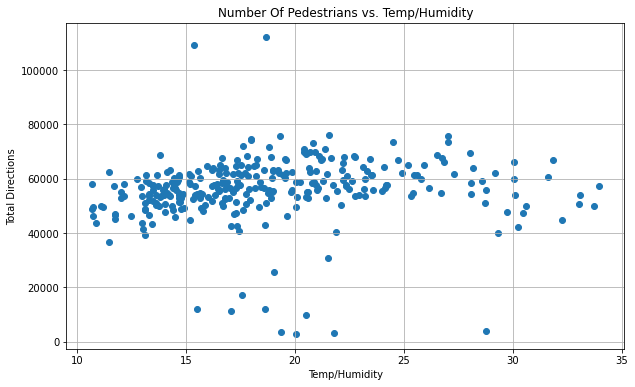

In [111]:
plt.figure(figsize=(10, 6))  
plt.scatter(df_agg[temp_or_hum], df_agg['Total_of_Directions'])  
plt.title('Number Of Pedestrians vs. Temp/Humidity')  
plt.xlabel('Temp/Humidity')  
plt.ylabel('Total Directions')  
plt.grid(True) 
plt.show()

## Visualize Median Pedestrian Traffic Based On Time

In [82]:
df_ped_median = df_merged.groupby('hour').agg({'Total_of_Directions': 'median'}).reset_index()

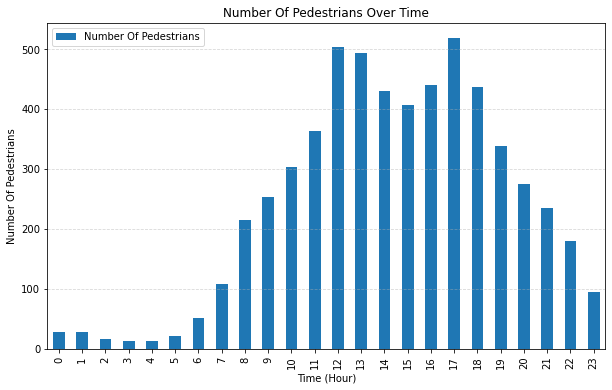

In [109]:
ax = df_ped_median.plot(kind='bar', figsize=(10, 6))

ax.set_title('Number Of Pedestrians Over Time')
ax.set_xlabel('Time (Hour)')
ax.set_ylabel('Number Of Pedestrians')
ax.legend(['Number Of Pedestrians'])
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()